# Metric Learning Homework

### Author: Denys Herasymuk

This notebook includes evaluation for a model on extra points:
* [optional] Fine-tuned using Triplet Loss

In [ ]:
from IPython.display import Image, HTML, clear_output
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install libraries

In [ ]:
# !pip install pytorch-metric-learning
# !pip install faiss-gpu
# clear_output()

In [ ]:
# !pip install albumentations
# !pip install annoy
# !pip install ml_metrics
# clear_output()

## Download dataset

In [ ]:
# !wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1TclrpQOF_ullUP99wk_gjGN8pKvtErG8' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1TclrpQOF_ullUP99wk_gjGN8pKvtErG8" -O stanford_online_products.zip && rm -rf /tmp/cookies.txt

--2022-12-23 20:12:03--  https://drive.google.com/uc?export=download&confirm=t&id=1TclrpQOF_ullUP99wk_gjGN8pKvtErG8
Resolving drive.google.com (drive.google.com)... 74.125.195.101, 74.125.195.100, 74.125.195.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-b4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ml9crq8pbf6macitcunsjnfmipjn16ur/1671826275000/04043966070551577705/*/1TclrpQOF_ullUP99wk_gjGN8pKvtErG8?e=download&uuid=f298a4c5-78dd-46ad-a7ff-d580e34c88c8 [following]
--2022-12-23 20:12:03--  https://doc-0s-b4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ml9crq8pbf6macitcunsjnfmipjn16ur/1671826275000/04043966070551577705/*/1TclrpQOF_ullUP99wk_gjGN8pKvtErG8?e=download&uuid=f298a4c5-78dd-46ad-a7ff-d580e34c88c8
Resolving doc-0s-b4-docs.googleusercontent.com (doc-0s-b4-docs.googleusercontent.com)... 74.125.20.1

In [ ]:
# !unzip ./stanford_online_products.zip
# clear_output()

In [ ]:
# !git clone https://github.com/denysgerasymuk799/UCU_CV_Metric_Learning_HW.git

Cloning into 'UCU_CV_Metric_Learning_HW'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 89 (delta 49), reused 64 (delta 24), pack-reused 0
Unpacking objects: 100% (89/89), done.


In [ ]:
# !git pull

## Import libraries

In [ ]:
import cv2
import random
import numpy as np
import pandas as pd
import albumentations as albu
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2 as ToTensor
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [ ]:
repo_path = '/content/UCU_CV_Metric_Learning_HW'
if os.getcwd() != repo_path:
  os.chdir(repo_path)
  print('Current working dir: ', os.getcwd())

Current working dir:  /content/UCU_CV_Metric_Learning_HW


In [ ]:
from src.data_preparation.prepare_datasets import get_data_transforms, get_files_metadata_dfs, get_datasets, get_data_loaders
from src.models.model_types import ModelTypes
from src.models.resenet_initializer import ResNetInitializer
from src.utils.annoy_utils import get_embedding, build_index, load_index
from src.utils.viz_utils import normalized_img_tensor_to_rgb, show_img, show_retrieval
from src.utils.fine_tuning import complex_criterion, fine_tune_model, fine_tune_arcface
from src.utils.model_evaluation import evaluate

## Define configs

In [ ]:
SEED = 42
VAL_FRACTION = 0.2
BATCH_SIZE = 64
NUM_WORKERS = 16
METRICS_K = 5

INDEX_MODEL_OUTPUT_SIZE = 512  # Length of item vector that will be indexed

ROOT_DATA_DIR = '/content/Stanford_Online_Products'
GDRIVE_DATA_DIR = '/content/drive/MyDrive/UCU/4course_1term/Computer_Vision/Practice/Metric_Learning_HW1/results'

In [ ]:
models_metrics_df = pd.DataFrame(columns=[
    'Model_Name',
    'Accuracy_Class_ID',
    'Accuracy_Superclass_ID',
    f'mAP@{METRICS_K}_Class_ID',
    f'mAP@{METRICS_K}_Superclass_ID'
])

## Create data loaders

In [ ]:
files_metadata_dfs = get_files_metadata_dfs(ROOT_DATA_DIR, VAL_FRACTION, SEED)

Train shape:  (47640, 4)
Val shape:  (11911, 4)
Test shape:  (60502, 4)


In [ ]:
num_superclasses = max([len(files_metadata_dfs[phase]['super_class_id'].unique()) for phase in ['train', 'val', 'test']])
print('Number of superclasses: ', num_superclasses)
num_classes = max([len(files_metadata_dfs[phase]['class_id'].unique()) for phase in ['train', 'val', 'test']])
print('Number of classes: ', num_classes)

Number of superclasses:  12
Number of classes:  11318


In [ ]:
datasets = get_datasets(files_metadata_dfs, ROOT_DATA_DIR)
data_loaders = get_data_loaders(datasets, BATCH_SIZE, NUM_WORKERS)
dataset_sizes = {
    'train': len(datasets['train']),
    'val': len(datasets['val']),
}

Class id: 908
Super Class id: 2



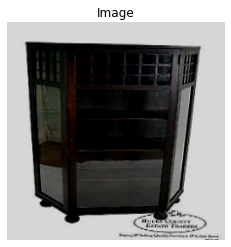

In [ ]:
show_img(datasets['train'], 4)

Class id: 11319
Super Class id: 1



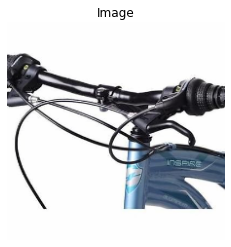

In [ ]:
show_img(datasets['test'], 4)

# Extra Task 5: Fine-tuned using Triplet Loss 

In [ ]:
from src.utils.fine_tuning import fine_tune_triplet

In [ ]:
resnet18_triplet_conf = ResNetInitializer(ModelTypes.TUNED_WITH_TRIPLET, num_superclasses, num_classes, embedding_size=INDEX_MODEL_OUTPUT_SIZE)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### Fine-tune the model

Do NOT take accuracy scores below into account, since the last Linear layer for this model is set to embedding_size (=512), but not to num_classes or num_superclasses, which is required by the loss. I just reused the same fine-tuning function as for the first two models of the homework with slight changes in the loss computation. And I understood that I did not need to compute accuracy for this model in such a way after analyzing results of all models. In any case, loss values are decreasing over time and final results with index retriaval are fine. 

In [ ]:
best_resnet18_triplet, optimizer_ft = fine_tune_triplet(resnet18_triplet_conf.model, data_loaders, dataset_sizes,
                                                        resnet18_triplet_conf.criterion, resnet18_triplet_conf.optimizer,
                                                        resnet18_triplet_conf.scheduler, resnet18_triplet_conf.mining_func, num_epochs=4)

Epoch 0/3
----------


100%|██████████| 745/745 [04:10<00:00,  2.98it/s]



train Loss: 0.3531 Acc [Classes]: 0.0001 Acc [Superclasses]: 0.0012


100%|██████████| 187/187 [00:51<00:00,  3.64it/s]



val Loss: 0.2943 Acc [Classes]: 0.0002 Acc [Superclasses]: 0.0002

Epoch 1/3
----------


100%|██████████| 745/745 [04:04<00:00,  3.05it/s]



train Loss: 0.2965 Acc [Classes]: 0.0002 Acc [Superclasses]: 0.0003


100%|██████████| 187/187 [00:48<00:00,  3.88it/s]



val Loss: 0.2734 Acc [Classes]: 0.0002 Acc [Superclasses]: 0.0001

Epoch 2/3
----------


100%|██████████| 745/745 [04:00<00:00,  3.10it/s]



train Loss: 0.2883 Acc [Classes]: 0.0001 Acc [Superclasses]: 0.0001


100%|██████████| 187/187 [00:49<00:00,  3.78it/s]



val Loss: 0.2708 Acc [Classes]: 0.0001 Acc [Superclasses]: 0.0000

Epoch 3/3
----------


100%|██████████| 745/745 [03:56<00:00,  3.14it/s]



train Loss: 0.2820 Acc [Classes]: 0.0001 Acc [Superclasses]: 0.0000


100%|██████████| 187/187 [00:48<00:00,  3.83it/s]


val Loss: 0.2665 Acc [Classes]: 0.0003 Acc [Superclasses]: 0.0000

Training complete in 19m 30s
Best val Acc [Classes]: 0.000168
Bests val Acc [Superclasses]: 0.000168


In [ ]:
# Set model to evaluation mode
best_resnet18_triplet.eval()

checkpoint = {
    'state_dict': best_resnet18_triplet.state_dict(),
    'optimizer': optimizer_ft.state_dict(),
}
torch.save(checkpoint, f'{GDRIVE_DATA_DIR}/{resnet18_triplet_conf.model_name}_fine_tuned_checkpoint.pth')

### Build an Index

In [ ]:
annoy_index = build_index(best_resnet18_triplet, datasets['train'], INDEX_MODEL_OUTPUT_SIZE,
                          resnet18_triplet_conf.model_name, num_trees=12, data_dir=GDRIVE_DATA_DIR)
annoy_index.get_nns_by_item(0, 5)

100%|██████████| 47640/47640 [09:03<00:00, 87.60it/s]



Number of skipped images because of errors: 0
Number of successfully saved images: 47640


[0, 46736, 4320, 1013, 23483]

### Evaluate the model

Load the best model and optimizer from the last checkpoint

In [ ]:
resnet18_triplet_conf = ResNetInitializer(ModelTypes.TUNED_WITH_TRIPLET, num_superclasses, num_classes, embedding_size=INDEX_MODEL_OUTPUT_SIZE)
best_resnet18_triplet = resnet18_triplet_conf.model
last_checkpoint = torch.load(f'{GDRIVE_DATA_DIR}/{resnet18_triplet_conf.model_name}_fine_tuned_checkpoint.pth')
optimizer_ft = last_checkpoint['optimizer']
best_resnet18_triplet.load_state_dict(last_checkpoint['state_dict'])
best_resnet18_triplet.eval()

MultilabelClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [ ]:
annoy_index = load_index(INDEX_MODEL_OUTPUT_SIZE, resnet18_triplet_conf.model_name, datasets['train'], data_dir=GDRIVE_DATA_DIR)

In [ ]:
models_metrics_df = evaluate(best_resnet18_triplet, resnet18_triplet_conf.model_name, models_metrics_df,
                             datasets['train'], datasets['val'], annoy_index, METRICS_K)

100%|██████████| 11911/11911 [07:13<00:00, 27.50it/s]




[resnet18_with_triplet_loss] Accuracy for class_id: 0.3317
[resnet18_with_triplet_loss] Accuracy for superclass_id: 0.7687
[resnet18_with_triplet_loss] mAP@5 for class_id: 0.3616
[resnet18_with_triplet_loss] mAP@5 for superclass_id: 0.8198


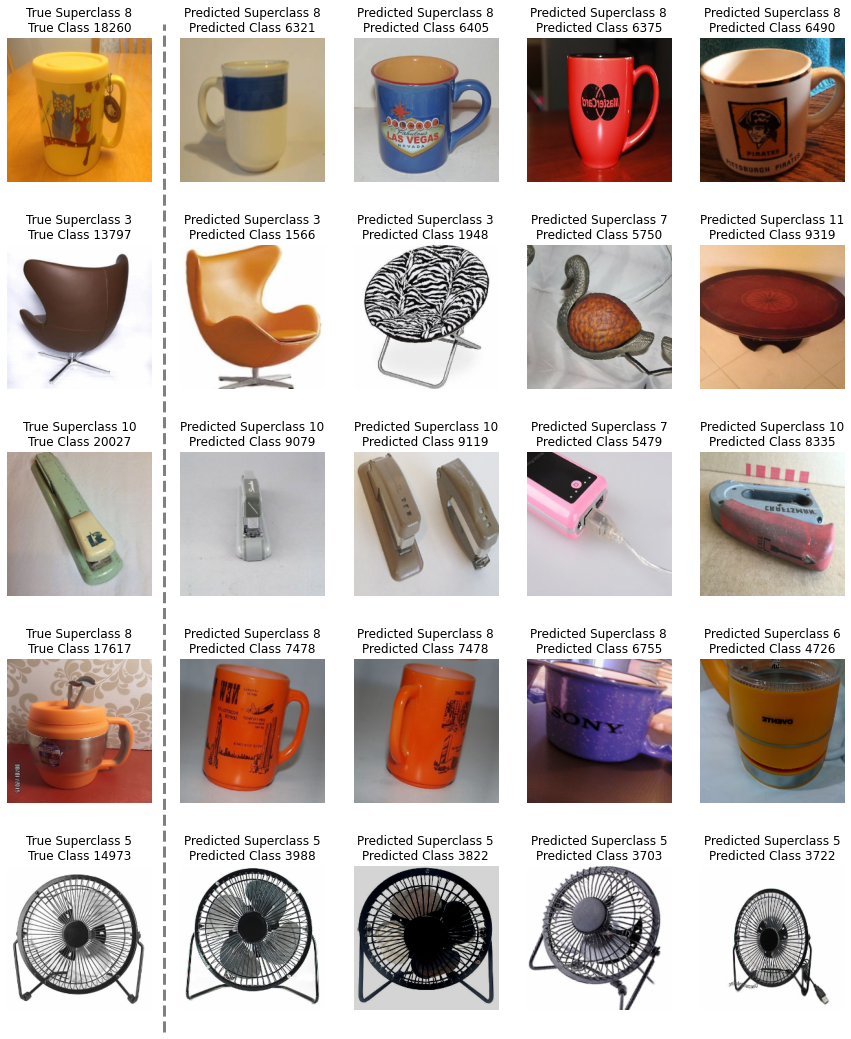

In [ ]:
show_retrieval(best_resnet18_triplet, annoy_index, datasets['train'], datasets['test'], k_closest=4)

In [ ]:
models_metrics_df

,Model_Name,Accuracy_Class_ID,Accuracy_Superclass_ID,mAP@5_Class_ID,mAP@5_Superclass_ID
0,resnet18_with_triplet_loss,0.3317,0.7687,0.3616,0.8198


In [ ]:
models_metrics_df.to_csv(f'{GDRIVE_DATA_DIR}/{resnet18_triplet_conf.model_name}_models_metrics_df.csv', index=False)

# Compare results of all models 

In [ ]:
import pandas as pd

filenames_with_metrics = []
for filename in os.listdir(GDRIVE_DATA_DIR):
    if 'metrics' in filename and 'self_supervised' not in filename and filename[-4:] == '.csv':
        filenames_with_metrics.append(filename)

In [ ]:
all_models_metrics_df = pd.DataFrame()
for filename in filenames_with_metrics:
    model_metrics_df = pd.read_csv(f'{GDRIVE_DATA_DIR}/{filename}')
    all_models_metrics_df = pd.concat([all_models_metrics_df, model_metrics_df])

In [ ]:
all_models_metrics_df = all_models_metrics_df.sort_values(by='mAP@5_Superclass_ID', ascending=False).reset_index(drop=True)
all_models_metrics_df

,Model_Name,Accuracy_Class_ID,Accuracy_Superclass_ID,mAP@5_Class_ID,mAP@5_Superclass_ID
0,resnet18_with_cross_entropy_loss,0.3870,0.8213,0.4214,0.8600
1,resnet18_siamese_with_contrastive_loss,0.3842,0.7879,0.4166,0.8342
2,resnet18_siamese_with_custom_contrastive_loss,0.3838,0.7812,0.4156,0.8306
3,resnet18_with_triplet_loss,0.3317,0.7687,0.3616,0.8198
4,resnet18_with_arcface_loss,0.1710,0.7333,0.1962,0.7861
5,plain_resnet18,0.0301,0.2178,0.0342,0.3345


In [ ]:
all_models_metrics_df.to_csv(f'{GDRIVE_DATA_DIR}/all_metric_learning_models_metrics.csv', index=False)